In [1]:
img_width, img_height = 224, 224
epochs = 30
batch_size = 32
num_classes = 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import csv
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import ViTFeatureExtractor, ViTForImageClassification
from datasets import load_dataset
import torch

C:\Users\Gabriel\anaconda3\envs\Tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
fold_1_dataset = load_dataset('imagefolder', data_dir='././brain_tumor_dataset/')
train_dir = "././brain_tumor_dataset"



In [27]:
train_datagen = ImageDataGenerator(rescale=1./255,    zoom_range=0.2,
    rotation_range=0.5,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2 )
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    class_mode='categorical',
    shuffle=True,
)

validation_generator = test_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_width, img_height),
    class_mode='categorical',
    shuffle=False,
    batch_size=batch_size,
)

Found 253 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


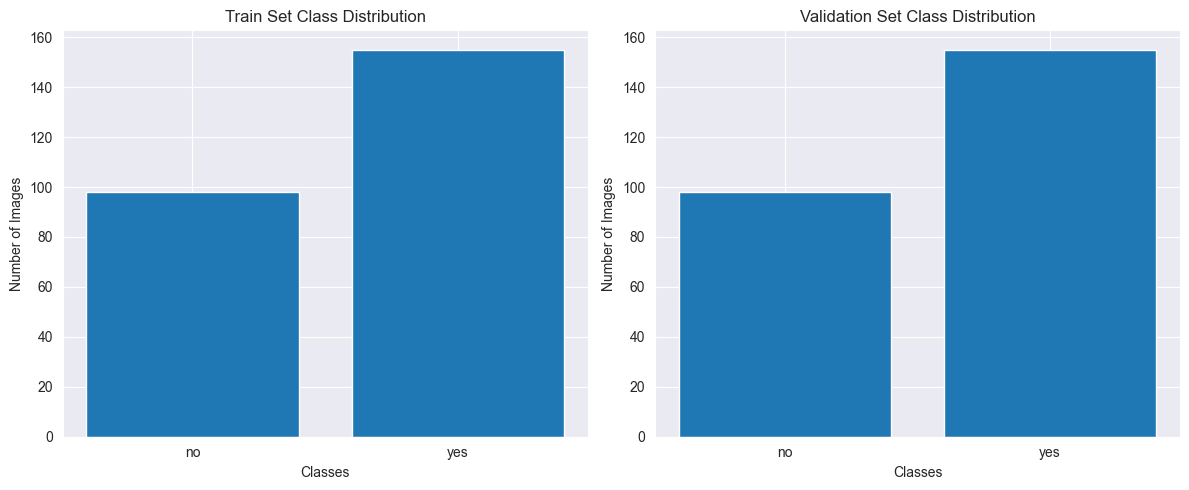

In [28]:
# Get class counts for train_generator
train_class_counts = np.bincount(train_generator.classes)

# Get class counts for validation_generator (test_generator)
val_class_counts = np.bincount(validation_generator.classes)

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for train_generator
axes[0].bar(class_labels, train_class_counts)
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Train Set Class Distribution')

# Plot histogram for validation_generator
axes[1].bar(class_labels, val_class_counts)
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Validation Set Class Distribution')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [29]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-large-patch32-224-in21k')

model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-224-in21k', num_labels=num_classes)

model.config.id2label = {i: str(i) for i in range(6)}

model.config.label2id = {str(i): i for i in range(6)}

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
split_dataset = fold_1_dataset['train'].train_test_split(test_size=0.2, seed=42)

print(split_dataset)

def preprocess(examples):
    examples['image'] = [img.convert('RGB') for img in examples['image']]
    examples['pixel_values'] = feature_extractor(examples['image'],return_tensors='pt').pixel_values
    return examples

dataset = split_dataset.map(preprocess, batched=True)
print(dataset)

Map: 100%|██████████| 51/51 [00:01<00:00, 37.41 examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'pixel_values'],
        num_rows: 202
    })
    test: Dataset({
        features: ['image', 'label', 'pixel_values'],
        num_rows: 51
    })
})


In [34]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./vit-image-classification",
    per_device_train_batch_size=batch_size,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    fp16=True,
    logging_dir='./vit-image-classification/logs',
    learning_rate=2e-4,
    save_total_limit=2,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args = training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
)

In [35]:
train_results = trainer.train()

C:\Users\Gabriel\anaconda3\envs\Tensorflow\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,No log,0.500963
2,No log,0.208431
3,No log,0.134486


C:\Users\Gabriel\anaconda3\envs\Tensorflow\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [36]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.13448603451251984, 'eval_runtime': 3.9227, 'eval_samples_per_second': 13.001, 'eval_steps_per_second': 1.784, 'epoch': 3.0}


In [37]:
predictions = trainer.predict(dataset['test'])
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

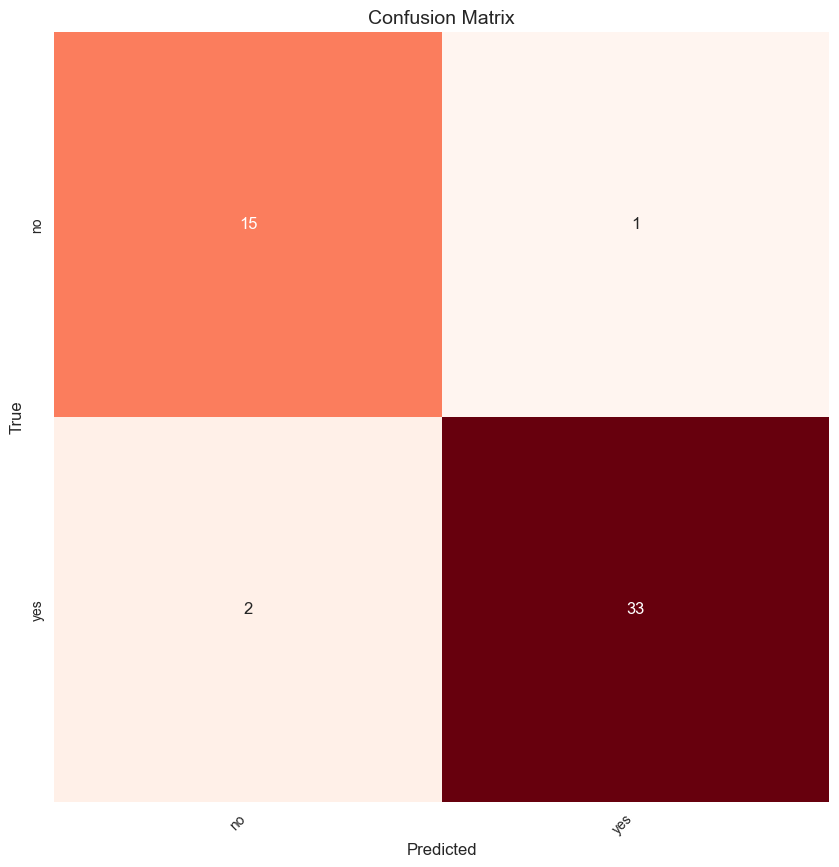

In [39]:
from sklearn.metrics import confusion_matrix

# Use true labels from dataset['test']
true_labels = dataset['test']['label']

# Ensure predicted_labels is aligned with true_labels
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sn.heatmap(confusion, annot=True, fmt="d", cmap="Reds", cbar=False,
           xticklabels=class_labels, yticklabels=class_labels,
           annot_kws={"size": 12})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [38]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

#show results
print('Confusion Matrix')
# Access the predictions from the PredictionOutput object and convert to NumPy array
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Assuming validation_generator.classes contains the true labels for your validation data
confusion = confusion_matrix(validation_generator.classes, predicted_labels)

# Adjust figure size for better visibility
plt.figure(figsize=(10, 10))  # Reduced figure size

# Create heatmap with annotations and labels
sn.heatmap(confusion, annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={"size": 12})  # Increased font size for annotations

plt.xlabel('Predicted', fontsize=12)  # Increased font size for x-axis label
plt.ylabel('True', fontsize=12)  # Increased font size for y-axis label
plt.title('Confusion Matrix', fontsize=14)  # Increased font size for title
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotated x-axis labels for better readability
plt.yticks(fontsize=10)  # Increased font size for y-axis labels
plt.show()

# Generate and print classification report
report = classification_report(true_labels, predicted_labels, target_names=dataset['train'].features['label'].names)
print(report)

Confusion Matrix


ValueError: Found input variables with inconsistent numbers of samples: [253, 51]